In [0]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import itertools
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

In [0]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [0]:
x = normal_dist.sample()

In [33]:
x

tensor(1.1703)

In [0]:
x = normal_dist.sample([100])

In [35]:
x

tensor([ 9.5947e-01, -5.6808e-01,  2.2568e+00,  1.6878e+00, -8.3937e-02,
         2.1099e-01, -3.0872e-01, -1.2366e-01, -1.2864e+00, -1.8052e-01,
        -7.4491e-01,  6.2527e-01, -1.2256e+00,  6.8100e-01, -2.6506e-01,
         7.3905e-01, -1.0274e-03,  5.8095e-01, -6.2256e-01, -1.2663e+00,
        -1.8376e-01, -8.3729e-01,  3.5513e-01, -1.2916e-01, -8.1556e-01,
         1.5365e+00,  3.0820e-01, -2.3973e-01,  6.9910e-01,  1.2599e+00,
         4.9197e-01, -3.6305e-01,  1.6510e-01,  1.9559e+00, -2.0298e-01,
        -7.4663e-01, -7.3795e-01, -7.9270e-01, -1.7287e-01,  1.5130e+00,
         1.8305e+00, -6.7202e-01,  2.3165e-01, -1.3704e+00, -4.1486e-02,
        -3.2633e-01,  2.1755e+00, -4.2317e-01,  1.0028e+00, -3.5716e-01,
        -7.4725e-01, -1.3898e+00,  6.5268e-01,  5.2362e-01, -2.6940e-02,
         1.3372e+00,  5.5868e-01,  8.1047e-01,  1.0785e+00, -5.1183e-02,
         1.2227e-01, -1.4348e+00,  1.9163e+00, -2.7883e-01,  1.0212e-01,
         1.4102e-01,  7.5990e-01,  5.6817e-01,  1.3

(array([ 3., 11., 13., 14., 18., 14., 12.,  5.,  6.,  4.]),
 array([-1.8517666 , -1.4409101 , -1.0300537 , -0.61919725, -0.20834084,
         0.2025156 ,  0.613372  ,  1.0242285 ,  1.4350849 ,  1.8459413 ,
         2.2567978 ], dtype=float32),
 <a list of 10 Patch objects>)

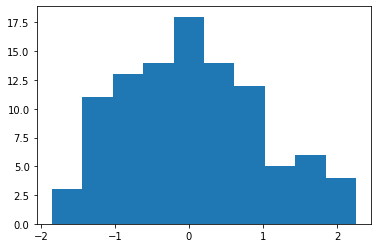

In [36]:
plt.hist(x.detach().numpy())

In [0]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    # linear_op = -3 - 4*x + x**2
    linear_op = 4 * torch.sin(x*2)
    y = torchdist.Normal(linear_op, 1).sample()
    return x, y

x_train, y_train = toy_poly()

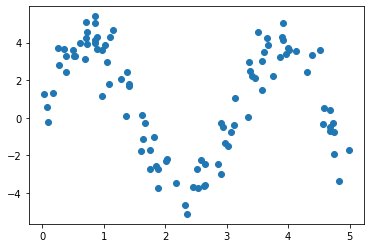

In [38]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

### multivariable gaussian

In [0]:
class CustomMultivariateNormal(torch.distributions.MultivariateNormal):
    def __init__(self, loc, covariance_matrix=None, precision_matrix=None, scale_tril=None, validate_args=None):
        super(CustomMultivariateNormal, self).__init__(
            loc, covariance_matrix, precision_matrix, scale_tril, validate_args)

    def __getattribute__(self, name):        
        if name == '_unbroadcasted_scale_tril':            
            # return F.relu(object.__getattribute__(self, name)) + 1e-4
            return F.relu(object.__getattribute__(self, name)).clamp(min=1e-8)
            # return torch.exp(object.__getattribute__(self, name))
        else:            
            return object.__getattribute__(self, name)

In [40]:
n_dim = 2
mu = nn.Parameter(torch.zeros(n_dim))
# log_sigma = nn.Parameter(torch.eye(n_dim).clamp(min=1e-8).log())
# sigma = torch.exp(log_sigma)
sigma = nn.Parameter(torch.cholesky(torch.eye(n_dim).clamp(1e-4)))
# sigma = nn.Parameter(torch.tensor([[2., 0.],[1., 1.]]).clamp(min=1e-4))

print(sigma)
# mvn = torchdist.MultivariateNormal(loc=mu, covariance_matrix=sigma)
mvn = CustomMultivariateNormal(loc=mu, scale_tril=sigma)

Parameter containing:
tensor([[1.0000e+00, 0.0000e+00],
        [1.0000e-04, 1.0000e+00]], requires_grad=True)


In [41]:
x1 = torch.tensor([3.0], requires_grad=True)
x2 = torch.tensor([0.0], requires_grad=True)
y = 2 * x1 + 3 * x2 + 1
y.backward()
print(x1.grad)
print(x2.grad)

tensor([2.])
tensor([3.])


In [42]:
a = mvn.rsample()
b = a.mean()
print(b.item())
b.backward()

0.012288033962249756


In [43]:
print(mu.grad)
print(sigma.grad)

tensor([0.5000, 0.5000])
tensor([[-0.3164,  0.0000],
        [-0.3164,  0.3287]])


In [44]:
a = torch.eye(3) + 1e-8
a1 = torch.cholesky(a)
print(a1)
b = a1.log()
print(b)
c = b.exp()
print(c)

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e-08, 1.0000e+00, 0.0000e+00],
        [1.0000e-08, 1.0000e-08, 1.0000e+00]])
tensor([[  0.0000,     -inf,     -inf],
        [-18.4207,   0.0000,     -inf],
        [-18.4207, -18.4207,   0.0000]])
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e-08, 1.0000e+00, 0.0000e+00],
        [1.0000e-08, 1.0000e-08, 1.0000e+00]])


In [0]:
class ParameterDistribution2:
    def __init__(self, dist, loc_dict):
        """
        Parameters
        ----------
        dist: torch.distributions.distribution.Distribution            
        """
        if not isinstance(dist, torch.distributions.Distribution):
            raise ValueError('dist must be torch.distributions.Distribution')
        self.dist = dist
        self.loc_dict = loc_dict

    def sample(self):
        with torch.no_grad():        
            w_sample = self.rsample()
        return w_sample

    def rsample(self):
        sample_1d = self.dist.rsample()
        w_sample = OrderedDict()
        for n, loc_info in self.loc_dict.items():
            loc = loc_info['loc']
            size = loc_info['size']
            sample = sample_1d[slice(*loc)]
            w_sample[n] = sample.view(*size)

        return w_sample

    def log_prob(self, w):
        """
        Parameters
        ----------
        w: dict
            key: parameter name
            value: torch.Tensor
        """ 
        return self.dist.log_prob(w)

def transform_param(w, loc_dict):
    param_dict = OrderedDict()
    for n, loc_info in loc_dict.items():
        loc = loc_info['loc']
        size = loc_info['size']
        sample = w[slice(*loc)]
        param_dict[n] = sample.view(*size)

    return param_dict


class VIModel2(nn.Module):
    def __init__(self, model):
        super(VIModel2, self).__init__()
        self.loc_dict, n_dim = self.get_params(model)
        
        self.mu = nn.Parameter(torch.zeros(n_dim))
        
        # self.sigma = nn.Parameter(torch.eye(n_dim))
        self.sigma = nn.Parameter(torch.cholesky(torch.eye(n_dim).clamp(1e-8)))
        # self.sigma = nn.Parameter(torch.eye(n_dim).clamp(1e-8))
        # TODO: __init__の中でcovariance_matrixをいじっているため2回目のbackwardで引っかかる
        self.dist = CustomMultivariateNormal(loc=self.mu, scale_tril=self.sigma)

        # log_sigma = torch.cholesky(torch.eye(n_dim) + 1e-8).log() - 32
        # self.log_sigma = nn.Parameter(log_sigma)
        # self.dist = CustomMultivariateNormal(loc=self.mu, scale_tril=self.log_sigma)

    def get_params(self, model):
        start = 0
        loc_dict = OrderedDict()
        for n, p in model.named_parameters():
            num = reduce(lambda x, y: x*y, p.size())
            end = start + num
            loc_info = {
                'size': p.size(),
                'loc': (start, end)
            }
            start = end
            
            loc_dict[n] = loc_info
        
        n_dim = start
        print(loc_dict)
        print(n_dim)
        return loc_dict, n_dim

def normal_prior_distV2(model):
    n_dim = 0
    for n, p in model.named_parameters():
        num = reduce(lambda x, y: x*y, p.size())
        n_dim += num

    mu = torch.zeros(n_dim)
    sigma = torch.eye(n_dim) * 10
    # dist = torchdist.MultivariateNormal(loc=mu, scale_tril=sigma)
    dist = CustomMultivariateNormal(loc=mu, scale_tril=sigma)
    return dist

def kl_divergenceV2(q_w, p_w, loc_dict, model, x, y, idx):

    # sampling from q(w)
    w_sample = q_w.rsample()
    # print('w_sample', w_sample)

    param_dict = transform_param(w_sample, loc_dict)
    # print('param_dict', param_dict)
    model.set_params(param_dict)

    # calculate f(x)
    # p(y|x,w) = N(f(x; w), 1)
    out1, out2 = model(x)
    if out1.size(-1) != 1:
        raise ValueError

    # print('output', output)
    p_y_xw = torchdist.Normal(out1, torch.ones_like(out1))
    # p_y_xw = torchdist.Normal(out1, out2)

    # log(p(w, x, y)) = log(p(w)) + sum(log(p(y|x,w)))
    val_log_p_w = p_w.log_prob(w_sample)
    # val_log_p_y_xw = p_y_xw.log_prob(y).mean()    
    val_log_p_y_xw = p_y_xw.log_prob(y).sum()
    # val_log_q_w = q_w.log_prob(w_sample)
    val_log_q_w = -q_w.entropy()

    if (idx+1) % 100 == 0:
        out_desc = out1.detach()
        print('%d loss q(w) %f p(w) %f p(y|xw) %f min %f mean %f max %f' 
              % (idx, val_log_q_w.item(), val_log_p_w.item(), val_log_p_y_xw.item(), 
                 out_desc.min(), out_desc.mean(), out_desc.max()))
    
    return val_log_q_w - val_log_p_w - val_log_p_y_xw
    # return val_log_q_w - val_log_p_y_xw
    # return - val_log_p_y_xw

## module

In [0]:
class CustomNormal(torch.distributions.Normal):
    def __init__(self, loc, scale, validate_args=None, eps=1e-4):
        super(CustomNormal, self).__init__(loc, scale, validate_args)
        self.eps = eps

    def __getattribute__(self, name):        
        if name == 'scale':            
            return torch.exp(object.__getattribute__(self, name)).clamp(min=self.eps)
        else:            
            return object.__getattribute__(self, name)


In [0]:
class TensorModule:
    def __init__(self):
        self.training = True
        self._parameters = OrderedDict()
        self._modules = OrderedDict()
        self._tmodules = OrderedDict()
        self._buffers = OrderedDict()

    def __call__(self, *input, **kwargs):
        result = self.forward(*input, **kwargs)
        return result
    
    def forward(self, *input):
        raise NotImplementedError

    def __setattr__(self, name, value):
        def remove_from(*dicts):
            for d in dicts:
                if name in d:
                    del d[name]

        params = self.__dict__.get('_parameters')
        if name.startswith('p_') and isinstance(value, torch.Tensor):
            if params is None:
                raise AttributeError
            remove_from(self.__dict__, self._buffers, self._modules)
            self.register_parameter(name, value)
        elif params is not None and name in params:
            if value is not None:
                raise TypeError
            self.register_parameter(name, value)
        else:
            modules = self.__dict__.get('_modules')
            if isinstance(value, TensorModule):
                if modules is None:
                    raise AttributeError
                remove_from(self.__dict__, self._parameters, self._buffers)
                modules[name] = value
            elif modules is not None and name in modules:
                if value is not None:
                    raise TypeError
                modules[name] = value
            else:
                buffers = self.__dict__.get('_buffers')
                if buffers is not None and name in buffers:
                    if value is not None and not isinstance(value, torch.Tensor):
                        raise TypeError
                    buffers[name] = value
                else:
                    object.__setattr__(self, name, value)

    def __getattr__(self, name):
        if '_parameters' in self.__dict__:
            _parameters = self.__dict__['_parameters']
            if name in _parameters:
                return _parameters[name]

        if '_buffers' in self.__dict__:
            _buffers = self.__dict__['_buffers']
            if name in _buffers:
                return _buffers[name]
        
        if '_modules' in self.__dict__:
            _modules = self.__dict__['_modules']
            if name in _modules:
                return _modules[name]

    def register_parameter(self, name, param):
        # debug
        if name in self._parameters:
            prev_param = self._parameters[name]
        else:
            prev_param = None
        # print('%s: %s -> %s' % (name, str(prev_param), str(param)))

        if '.' in name:
            raise KeyError

        if param is None:
            self._parameters[name] = None
        elif not isinstance(param, torch.Tensor):
            raise TypeError
        else:
            self._parameters[name] = param

    def register_buffer(self, name, tensor):
        if '.' in name:
            raise KeyError
        elif tensor is not None and not isinstance(tensor, torch.Tensor):
            raise TypeError
        else:
            self._buffers[name] = tensor

    def named_modules(self, memo=None, prefix=''):
        if memo is None:
            memo = set()
        if self not in memo:
            memo.add(self)
            yield prefix, self
            for name, module in self._modules.items():
                if module is None:
                    continue
                submodule_prefix = prefix + ('.' if prefix else '') + name
                for m in module.named_modules(memo, submodule_prefix):
                    yield m   

    def _named_members(self, get_members_fn, prefix='', recurse=True):
        memo = set()
        modules = self.named_modules(prefix=prefix) if recurse else [(prefix, self)]
        for module_prefix, module in modules:
            members = get_members_fn(module)
            for k, v in members:
                if v is None or v in memo:
                    continue
                memo.add(v)
                name = module_prefix + ('.' if module_prefix else '') + k
                yield name, v

    def named_parameters(self, prefix='', recurse=True):
        gen = self._named_members(
            lambda module: module._parameters.items(),
            prefix=prefix, recurse=True
        )
        for elem in gen:
            yield elem

    def _load_from_state_dict(self, state_dict, prefix):
        local_name_params = itertools.chain(self._parameters.items(), self._buffers.items())
        local_state = {k: v for k, v in local_name_params if v is not None}

        for name, param in local_state.items():
            key = prefix + name
            if key in state_dict:
                input_param = state_dict[key]
                setattr(self, name, input_param)
                # with torch.no_grad():                        
                # param.copy_(input_param)

    def set_params(self, state_dict):
        def load(module, prefix=''):
            module._load_from_state_dict(state_dict, prefix)
        
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        load(self)
        load = None
        
    def train(self, mode=True):
        self.training =  mode
        for module in self.children():
            module.train(mode)
        return self

    def eval(self):
        return self.train(False)

    def children(self):
        for name, module in self.named_children():
            yield module

    def named_children(self):
        memo = set()
        for name, module in self._modules.items():
            if module is not None and module not in memo:
                memo.add(module)
                yield name, module

class TensorLinear(TensorModule):
    def __init__(self, in_features, out_features, bias=True):
        super(TensorLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        # self.weight = TensorParameter((out_features, in_features))
        self.p_weight = torch.zeros((out_features, in_features), dtype=torch.float32)
        if bias:
            self.p_bias = torch.zeros((out_features, ), dtype=torch.float32)
        else:
            # original self.register_parameter('bias', None)
            self.p_bias = None

    def forward(self, input):
        return F.linear(input, self.p_weight, self.p_bias)

In [0]:
class _NormBase(TensorModule):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(_NormBase, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.p_weight = torch.Tensor(num_features)
            self.p_bias = torch.Tensor(num_features)
        else:
            self.register_parameter('p_weight', None)
            self.register_parameter('p_bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            torch.nn.init.ones_(self.p_weight)
            torch.nn.init.zeros_(self.p_bias)

class _BatchNorm(_NormBase):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, 
                 track_running_stats=True):
        super(_BatchNorm, self).__init__(num_features, eps, momentum, affine,
                                         track_running_stats)
    
    def forward(self, input):
        self._check_input_dim(input)

        if self.momentum is None:
            exponential_average_factor = 0.0
        else:
            exponential_average_factor = self.momentum

        if self.training and self.track_running_stats:            
            if self.num_batches_tracked is not None:
                self.num_batches_tracked = self.num_batches_tracked + 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        return F.batch_norm(
            input, self.running_mean, self.running_var, self.p_weight, self.p_bias,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)
        

class TensorBatchNorm1d(_BatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 2 and input.dim() !=3:
            raise ValueError('invalid dim')

In [0]:
class TensorLinearNet(TensorModule):
    def __init__(self):
        super(TensorLinearNet, self).__init__()
        n = 8
        self.linear1 = TensorLinear(1, n)
        self.linear2 = TensorLinear(n, n)
        # self.linear3 = TensorLinear(n, n)
        # self.linear4 = TensorLinear(n, n)

        self.last_layer = TensorLinear(n, 1)

        self.bn1 = TensorBatchNorm1d(n)
        self.bn2 = TensorBatchNorm1d(n)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # x = self.linear3(x)
        # x = F.relu(x)

        # x = self.linear4(x)
        x = self.last_layer(x)

        x1 = x
        x2 = None

        return x1, x2

class TensorLinearNet2(TensorModule):
    def __init__(self):
        super(TensorLinearNet2, self).__init__()
        self.linear11 = TensorLinear(1, 8)
        self.linear12 = TensorLinear(8, 1)
        self.linear21 = TensorLinear(1, 8)
        self.linear22 = TensorLinear(8, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear11(x)        
        x = self.relu(x)
        x = self.linear12(x)

        x2 = x*x
        x2 = self.linear21(x2)
        x2 = self.relu(x2)
        x2 = self.linear22(x2)
        
        x = x + x2
        
        return x, None

## model

In [0]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
    def forward(self, w, x):
        """
        w: shape of (3,)
        x: shape of (batch,)
        """
        #         phi_x = torch.tensor([])
        y = w[0] + w[1]*x + w[2]*x**2
        return y

class LinearNet2(nn.Module):
    def __init__(self):
        super(LinearNet2, self).__init__()

        self.linear1 = nn.Linear(1, 8)
        self.linear2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)

        return x

In [0]:
class ParameterDistribution:
    def __init__(self, dist):
        """
        Parameters
        ----------
        dist: dict
            key: paramter name
            value: torch.distributions.distribution.Distribution
        """
        if not isinstance(dist, OrderedDict):
            raise ValueError('dist must be OrderedDict')
        self.dist = dist

    def sample(self):
        w_sample = OrderedDict()
        for n, d in self.dist.items():
            w_sample[n] = d.sample()

        return w_sample

    def rsample(self):
        w_sample = OrderedDict()
        for n, d in self.dist.items():
            w_sample[n] = d.rsample()

        return w_sample

    def log_prob(self, w):
        """
        Parameters
        ----------
        w: dict
            key: parameter name
            value: torch.Tensor
        """
        sum_log_prob = 0
        for k, v in w.items():
            distribution = self.dist[k]
            sum_log_prob += distribution.log_prob(v).sum()

        return sum_log_prob

class VIModel(nn.Module):
    def __init__(self, model):
        super(VIModel, self).__init__()
        # set param

        param_dict = self.get_params(model)
        self.dist = self.normal_dist(param_dict)        
        self.__setparams(param_dict)        

    def get_params(self, model):
        param_dict = OrderedDict()
        for n, p in model.named_parameters():
            mu = nn.Parameter(torch.zeros_like(p.data))
            log_sigma = nn.Parameter(torch.zeros_like(p.data))
            
            eta_dict = {
                'mu': mu,
                'log_sigma': log_sigma
            }
            param_dict[n] = eta_dict

        return param_dict

    def normal_dist(self, param_dict):
        dist = OrderedDict()
        for n, eta_dict in param_dict.items():
            mu = eta_dict['mu']
            log_sigma = eta_dict['log_sigma']
            # sigma = torch.exp(log_sigma)

            # dist[n] = torchdist.Normal(mu, sigma)
            dist[n] = CustomNormal(mu, log_sigma)

        return dist

    def __setparams(self, param_dict):
        for n, eta_dict in param_dict.items():
            for eta_name, eta_param in eta_dict.items():
                # parameter
                name =  '_'.join([n.replace('.', '_'), eta_name])
                setattr(self, name, eta_param)
                

def normal_dist(model):
    dist = OrderedDict()
    for n, p in model.named_parameters():
        mu = nn.Parameter(torch.zeros_like(p.data))
        sigma = torch.exp(nn.Parameter(torch.zeros_like(p.data)))        
        dist[n] = torchdist.Normal(mu, sigma)

    return dist

def normal_prior_dist(model):
    dist = OrderedDict()
    for n, p in model.named_parameters():
        param_size = p.size()        
        mu = torch.zeros(param_size)
        # [10, 10, ...]
        sigma = torch.zeros((1,)).new_full(param_size, 10.0)
        dist[n] = torchdist.Normal(mu, sigma)

    return dist

In [0]:
def kl_divergence(q_w, p_w, model, x, y, n_params, idx):

    # sampling from q(w)
    w_sample = q_w.rsample()
    
    model.set_params(w_sample)

    # calculate f(x)
    # p(y|x,w) = N(f(x; w), 1)
    out1, out2 = model(x)

    # print('output', output)
    p_y_xw = torchdist.Normal(out1, torch.ones_like(out1) / 2)
    # p_y_xw = torchdist.Normal(out1, out2)

    # log(p(w, x, y)) = log(p(w)) + sum(log(p(y|x,w)))    
    # val_log_joint_prob = p_w.log_prob(w_sample) + p_y_xw.log_prob(y).sum()    
    val_log_p_w = p_w.log_prob(w_sample) / n_params
    # val_log_p_w = p_w.log_prob(w_sample)
    val_log_p_y_xw = p_y_xw.log_prob(y).mean()
    val_log_q_w = q_w.log_prob(w_sample) / n_params
    # val_log_q_w = q_w.log_prob(w_sample)

    if (idx+1) % 100 == 0:
        print('%d loss q(w) %f p(w) %f p(y|xw) %f' 
              % (idx, val_log_q_w.item(), val_log_p_w.item(), val_log_p_y_xw.item()))
    
    return val_log_q_w - val_log_p_w - val_log_p_y_xw
    # return - val_log_p_y_xw

def kl_divergence_nsamples(q_w, p_w, loc_dict, model, x, y, idx):

    val_loss = 0
    n_samples = 10
    for _ in range(n_samples):
        val_loss += kl_divergenceV2(q_w, p_w, loc_dict, model, x, y, idx) / n_samples
    return val_loss


def loss_func(model, x, y):
    y_pred = model(x)
    loss = ((y - y_pred)**2).mean()
    return loss

def freeze_param(model):
    for p in model.parameters():
        p.requires_grad = False

def setw(module, w_dict, prefix):
    var_names = list(module._parameters.keys())
    for var_name in var_names:
        if prefix == '':
            full_name = var_name
        else:
            full_name = '.'.join([prefix, var_name])
        print(full_name)
        value = w_dict[full_name]        
        # module.__setattr__ == 
        
        # value_param =  nn.Parameter(value, requires_grad=False)
        # dengerous process
        value.__class__ = nn.Parameter
        setattr(module, var_name, value)
        print('test')
        # module.register_parameter(var_name, value_param)
        # module._parameters[var_name] = value
        
    for child_name, child_module in module._modules.items():
        if prefix == '':
            child_full_name = child_name
        else:
            child_full_name = '.'.join([prefix, child_name])
        setw(child_module, w_dict, child_full_name)

def printw(module, prefix=''):
    var_names = list(module._parameters.keys())
    for var_name in var_names:        
        if prefix == '':
            full_name = var_name
        else:
            full_name = '.'.join([prefix, var_name])
        print(full_name)
        print(getattr(module, var_name))        

    for child_name, child_module in module._modules.items():
        if prefix == '':
            child_full_name = child_name
        else:
            child_full_name = '.'.join([prefix, child_name])
        printw(child_module, child_full_name)

def write_graph(writer, model, x):
    writer.add_graph(model, input_to_model=x)

def get_n_params(model):
    n_all_params = 0
    for n, p in model.named_parameters():
        if p is not None:
            n_params = 1
            for dim in p.size():
                n_params *= dim
            n_all_params += n_params
    return n_all_params

## exec

Calculate prediction distribution
$$
\begin{align}
& KL[q(W; \eta)||p(W|X, Y)] \\
&= \int q(W; \eta) \log \frac{q(W; \eta)}{p(W|X, Y)} dW\\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log \frac{p(Y|W, X)p(W)}{p(Y|X)}dW \\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log p(Y|W, X)dW - \int q(W; \eta) \log p(W)dW + const.\\
&= E[\log q(W; \eta)] - E[\log p(Y|W, X)] - E[\log p(W)] + const.
\end{align}
$$

In [53]:
scaler = StandardScaler()
x_train_norm = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)

# model = LinearNet2()
model = TensorLinearNet()
vimodel = VIModel2(model)
q_w = vimodel.dist
p_w = normal_prior_distV2(model)

# optimizer = torch.optim.Adam(params=vimodel.parameters(), lr=5e-4)
optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-5, 
                            momentum=0.9,
                            weight_decay=1e-4)

OrderedDict([('linear1.p_weight', {'size': torch.Size([8, 1]), 'loc': (0, 8)}), ('linear1.p_bias', {'size': torch.Size([8]), 'loc': (8, 16)}), ('linear2.p_weight', {'size': torch.Size([8, 8]), 'loc': (16, 80)}), ('linear2.p_bias', {'size': torch.Size([8]), 'loc': (80, 88)}), ('last_layer.p_weight', {'size': torch.Size([1, 8]), 'loc': (88, 96)}), ('last_layer.p_bias', {'size': torch.Size([1]), 'loc': (96, 97)}), ('bn1.p_weight', {'size': torch.Size([8]), 'loc': (97, 105)}), ('bn1.p_bias', {'size': torch.Size([8]), 'loc': (105, 113)}), ('bn2.p_weight', {'size': torch.Size([8]), 'loc': (113, 121)}), ('bn2.p_bias', {'size': torch.Size([8]), 'loc': (121, 129)})])
129


In [54]:
n_params = get_n_params(model)
model.train()
for i in range(10000):    
    with torch.set_grad_enabled(True):    
        optimizer.zero_grad()        
        loss = kl_divergence_nsamples(q_w, p_w, vimodel.loc_dict, model, x_train_norm, y_train, i)
        loss.backward()
        optimizer.step()        
        
    if str(loss.item()) == 'nan':
        break

    if (i+1) % 100== 0:
        # mu = vimodel.eta_mu.detach().numpy()
        # sigma = torch.exp(vimodel.eta_log_sigma.detach()).numpy()
        # print('loss: %f mu: %s sigma: %s' % (loss.detach().numpy(), str(mu), str(sigma)))
        # print(loss.size())
        print('iter: %d loss: %f ' % (i, loss.item(),))


99 loss q(w) -174.651291 p(w) -416.189697 p(y|xw) -476.719513 min 1.135807 mean 1.427819 max 1.821273
99 loss q(w) -174.651291 p(w) -416.118439 p(y|xw) -699.060425 min -3.490112 mean 0.383341 max 6.257768
99 loss q(w) -174.651291 p(w) -416.208374 p(y|xw) -529.508911 min -1.873231 mean -0.039258 max 1.140490
99 loss q(w) -174.651291 p(w) -416.142029 p(y|xw) -494.413757 min 0.040293 mean 0.578379 max 1.118329
99 loss q(w) -174.651291 p(w) -416.226868 p(y|xw) -456.993958 min 0.572834 mean 0.932189 max 1.412390
99 loss q(w) -174.651291 p(w) -416.051788 p(y|xw) -498.828003 min 0.196843 mean 0.511165 max 0.806414
99 loss q(w) -174.651291 p(w) -416.244690 p(y|xw) -517.712585 min -0.142879 mean 0.547055 max 1.164692
99 loss q(w) -174.651291 p(w) -416.136932 p(y|xw) -501.192352 min 1.008643 mean 1.222236 max 1.915819
99 loss q(w) -174.651291 p(w) -416.074799 p(y|xw) -498.204681 min -1.740955 mean 0.540804 max 2.427521
99 loss q(w) -174.651291 p(w) -416.241394 p(y|xw) -561.897095 min -0.094409 m

In [55]:
for n, p in vimodel.named_parameters():
    print(n, p)

mu Parameter containing:
tensor([-2.1741e+00, -1.7299e+00,  6.3600e-01,  3.7746e+00,  1.7561e+00,
        -6.1776e-01,  1.1017e+00,  1.5583e+00, -8.0886e-05,  9.1630e-05,
        -5.7420e-05, -7.9344e-06, -4.4439e-05,  3.7608e-05, -5.0530e-05,
        -3.3642e-05,  5.5129e-02, -2.1228e-02, -3.6699e-02, -2.7252e-02,
        -3.3028e-02, -5.8130e-02, -1.8172e-02, -9.8003e-03,  2.2906e-02,
         3.6961e-02, -4.0465e-02,  3.9633e-02, -2.8441e-02,  7.9354e-03,
        -4.1824e-02,  1.0194e-02, -3.4751e-03, -6.4742e-02,  8.7381e-02,
        -3.9801e-02,  2.0867e-02,  5.9676e-03,  3.1620e-03,  3.3781e-02,
         4.2896e-02, -3.4522e-02, -3.6323e-03, -2.4273e-02, -6.2451e-02,
        -2.9428e-02, -1.0666e-02, -1.1324e-02, -1.7919e-02,  4.0886e-02,
         3.0650e-02,  1.8477e-02,  1.8708e-02, -5.1553e-02, -4.2382e-02,
         3.8981e-02,  3.3446e-02,  3.0206e-03,  5.5313e-02,  1.1010e-02,
         2.5643e-02,  4.4561e-03, -1.9356e-02,  4.0031e-02,  7.2665e-02,
         6.7236e-03,  7.45

## prediction

Calculate prediction distribution
$$
\begin{align}
p(y_*| x_*, X, Y) &= \int p(y_*| x_*, W) p(W| X, Y) dW \\
&\approx \int p(y_*| x_*, W) q(W; \eta) dW 
\end{align}
$$

In [0]:
def predict(q_w, loc_dict, model, x, n_samples):    
    
    approx_y = 0  
    model.eval()  
    with torch.no_grad():
        for i in range(n_samples):
            # sampling from q(w)
            w_sample = q_w.sample()

            param_dict = transform_param(w_sample, loc_dict)
            model.set_params(param_dict)
            # calculate f(x)
            out1, out2 = model(x)

            # p(y|x,w) = N(f(x; w), 1)
            p_y_xw = torchdist.Normal(out1, torch.ones_like(out1))
            # p_y_xw = torchdist.Normal(out1, out2)

            # sampling from p(y, w)
            y_sample = p_y_xw.sample()

            approx_y += y_sample / n_samples
    
    return approx_y

In [0]:
def predict_data(q_w, loc_dict, model):
    n_samples = 1000
    x_pred = 5 * torch.rand(100, 1)
    x_pred = torch.tensor(scaler.transform(x_pred), dtype=torch.float32)
    y_pred = predict(q_w, loc_dict, model, x_pred, n_samples)
    
    return x_pred, y_pred


3


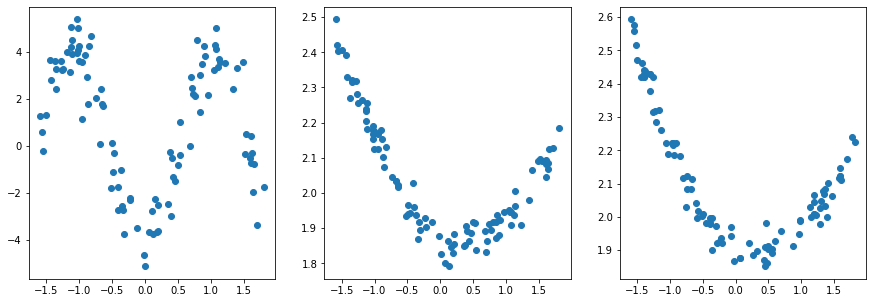

In [60]:
x_pred, y_pred = predict_data(q_w, vimodel.loc_dict, model)
y_pred_train = predict(q_w, vimodel.loc_dict, model, x_train_norm, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print(len(axes))
axes[0].plot(x_train_norm.numpy(), y_train.numpy(), 'o')
axes[1].plot(x_train_norm.numpy(), y_pred_train.numpy(), 'o')
axes[2].plot(x_pred.numpy(), y_pred.numpy(), 'o')